In [ ]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 10.4 MB/s eta 0:00:00


In [ ]:
# %% - Andriy Drozdyuk

# Import necessary libraries
import torch
import numpy as np
import gymnasium as gym

# Hyperparameters for training
max_steps = 50_000   # Maximum number of training steps
step = 0             # Initialize step counter
lr = 0.005           # Learning rate
γ = 0.9999           # Discount factor for future rewards

# Create the CartPole environment
env = gym.make('CartPole-v1')

# Define the policy network (a simple feedforward neural network)
nn = torch.nn.Sequential(
    torch.nn.Linear(4, 64),           # 4 input features (state), 64 hidden units
    torch.nn.ReLU(),                  # ReLU activation function
    torch.nn.Linear(64, env.action_space.n), # Output layer with number of actions in the environment
    torch.nn.Softmax(dim=-1)          # Softmax activation to get action probabilities
)

# Set up the Adam optimizer
optim = torch.optim.Adam(nn.parameters(), lr=lr)

# File paths for saving training results
folder_path='/content/drive/MyDrive/Models/foler_path/'
scores_file=f'scores2.npy'          # File to save scores
running_scores_file=f'running-scores2.npy'  # File to save running scores
loss_file = f'losses2.npy'          # File to save losses

# Lists to store scores, losses, and running scores
scores, losses, running_scores = [], [], []

# Initialize running reward to track performance over time
running_reward = 10

# Training loop for the policy
while step <= max_steps:
    # Reset the environment for each episode
    obs = torch.tensor(env.reset()[0], dtype=torch.float)
    done = False
    Actions, States, Rewards = [], [], []  # Lists to store actions, states, and rewards for each episode
    score = 0  # Initialize score for this episode

    while not done:
        # Get action probabilities from the policy network (neural network)
        probs = nn(obs)
        # Create a categorical distribution from the probabilities
        dist = torch.distributions.Categorical(probs=probs)
        # Sample an action from the distribution
        action = dist.sample().item()
        # Execute the action in the environment and get the new state, reward, and done flag
        obs_, rew, done, _, _ = env.step(action)

        # Store the action, state, and reward
        Actions.append(torch.tensor(action, dtype=torch.int))
        States.append(obs)
        Rewards.append(rew)
        score += rew  # Update the score for this episode

        # Update the observation for the next step
        obs = torch.tensor(obs_, dtype=torch.float)

        # Increment the global step counter
        step += 1

    # Update the running reward for performance tracking
    running_reward = 0.05 * score + (1 - 0.05) * running_reward
    running_scores.append(running_reward)
    scores.append(score)

    # Compute the discounted returns (G) for each time step in the episode
    DiscountedReturns = []
    for t in range(len(Rewards)):
        G = 0.0
        for k, r in enumerate(Rewards[t:]):
            G += (γ**k) * r  # Compute the discounted reward for future time steps
        DiscountedReturns.append(G)

    # Update the policy using the computed discounted returns
    for State, Action, G in zip(States, Actions, DiscountedReturns):
        # Get the action probabilities for the current state from the policy network
        probs = nn(State)
        print(f'probs {probs}')  # Print the action probabilities
        print(f'action {Action}')  # Print the action taken
        # Create a categorical distribution from the action probabilities
        dist = torch.distributions.Categorical(probs=probs)
        print(f' size of dist {dist}')  # Print the distribution size
        # Calculate the log probability of the taken action
        log_prob = dist.log_prob(Action)
        print(f'log prob shape {log_prob}')  # Print the log probability of the action

        # Compute the loss (negative log probability * discounted return)
        loss = - log_prob * G
        print(f'loss {loss}')  # Print the computed loss
        losses.append(loss)  # Append the loss to the losses list

        # Perform backpropagation and update the policy network
        optim.zero_grad()    # Zero the gradients
        loss.backward()      # Backpropagate the loss
        optim.step()         # Perform an optimization step

# Save the results (scores, running scores, and losses) to files
np.save(f'{folder_path}{scores_file}', scores)
np.save(f'{folder_path}{running_scores_file}', running_scores)

# Convert tensor losses to numpy arrays for saving
losses = [l.detach().cpu().numpy() if isinstance(l, torch.Tensor) else l for l in losses]
np.save(f'{folder_path}{loss_file}', losses)


# %% Play

# After training, test the learned policy by running it for 5 episodes
for _ in range(5):
    Rewards = []

    # Reset the environment and render it
    obs = torch.tensor(env.reset()[0], dtype=torch.float)
    done = False
    env.render()  # Render the environment to visualize the agent's actions

    while not done:
        # Get action probabilities from the policy network
        probs = nn(obs)
        # Create a categorical distribution and sample an action
        c = torch.distributions.Categorical(probs=probs)
        action = c.sample().item()

        # Execute the action in the environment and get the next observation, reward, and done flag
        obs_, rew, done, _info, _ = env.step(action)
        env.render()  # Render the environment to visualize the action

        # Update the observation
        obs = torch.tensor(obs_, dtype=torch.float)

        # Accumulate rewards
        Rewards.append(rew)

    # Print the total reward for this test run
    print(f'Reward: {sum(Rewards)}')

# Close the environment after testing
env.close()

# %%


Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
probs tensor([0.2245, 0.7755], grad_fn=<SoftmaxBackward0>)
action 1
 size of dist Categorical(probs: torch.Size([2]))
log prob shape -0.25422701239585876
loss 24.793798446655273
probs tensor([0.8266, 0.1734], grad_fn=<SoftmaxBackward0>)
action 0
 size of dist Categorical(probs: torch.Size([2]))
log prob shape -0.19048361480236053
loss 18.38850212097168
probs tensor([0.3568, 0.6432], grad_fn=<SoftmaxBackward0>)
action 1
 size of dist Categorical(probs: torch.Size([2]))
log prob shape -0.44126105308532715
loss 42.16047668457031
probs tensor([0.9485, 0.0515], grad_fn=<SoftmaxBackward0>)
action 0
 size of dist Categorical(probs: torch.Size([2]))
log prob shape -0.052886962890625
loss 5.000720500946045
probs tensor([0.6650, 0.3350], grad_fn=<SoftmaxBackward0>)
action 1
 size of dist Categorical(probs: torch.Size([2]))
log prob shape -1.093591570854187
loss 102.32106018066406
probs tensor([0.9911, 0.0089], grad_fn=<SoftmaxBac

/usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:250: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("CartPole-v1", render_mode="rgb_array")
  gym.logger.warn(


ValueError: too many values to unpack (expected 4)

In [ ]:
env = gym.make('CartPole-v1', render_mode="rgb_array")
# %% Play

for _ in range(5):
    Rewards = []

    obs = torch.tensor(env.reset()[0], dtype=torch.float)
    done = False
    env.render()

    while not done:
        probs = nn(obs)
        c = torch.distributions.Categorical(probs=probs)
        action = c.sample().item()

        obs_, rew, done, _info ,_= env.step(action)
        env.render()

        obs = torch.tensor(obs_, dtype=torch.float)

        Rewards.append(rew)


    print(f'Reward: {sum(Rewards)}')
env.close()

Reward: 99.0
Reward: 117.0
Reward: 29.0
Reward: 25.0
Reward: 39.0


In [ ]:
#  Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install gymnasium

In [ ]:
import numpy as np
folder_path='/content/drive/My Drive/Models/folder_path/'
file_path='losses2.npy'
RS_path='running-scores2.npy'
scores_file='scores2.npy'

# Load the .npy file from Google Drive
losses = np.load(f'{folder_path}{file_path}')
scores = np.load(f'{folder_path}{scores_file}')
running_scores = np.load(f'{folder_path}{RS_path}')

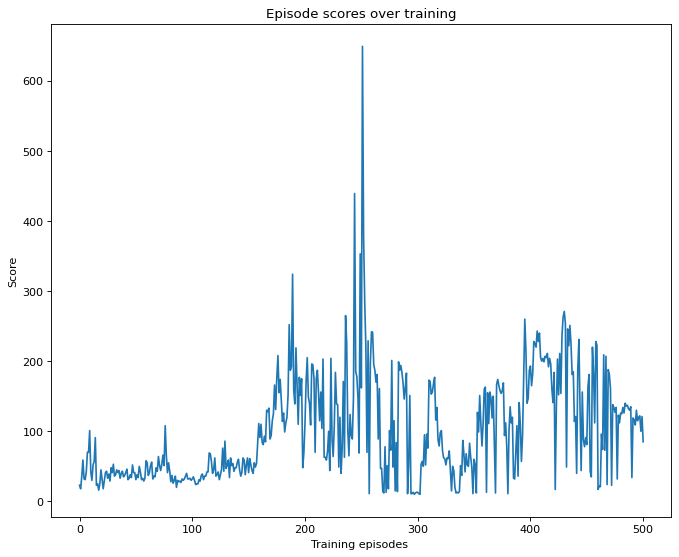

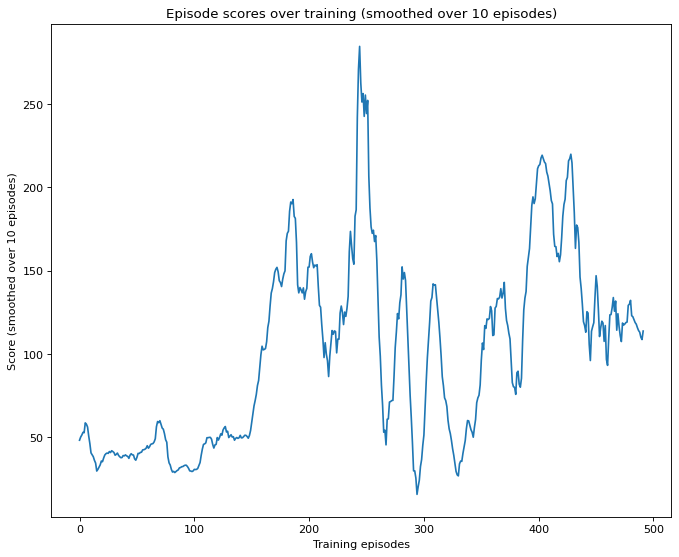

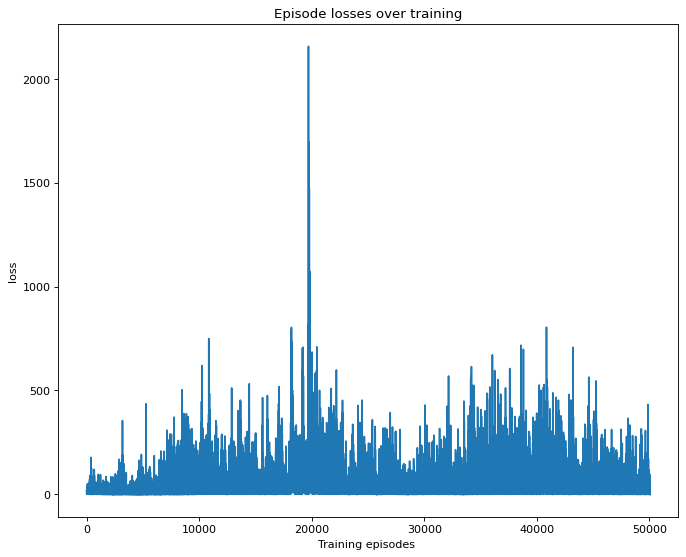

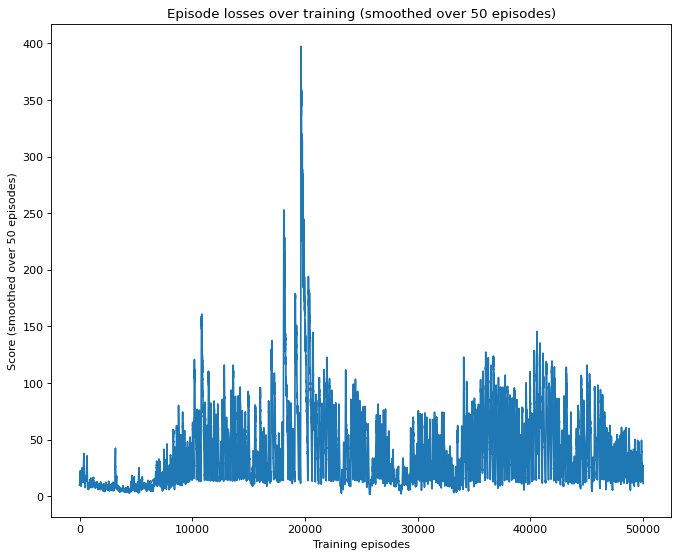

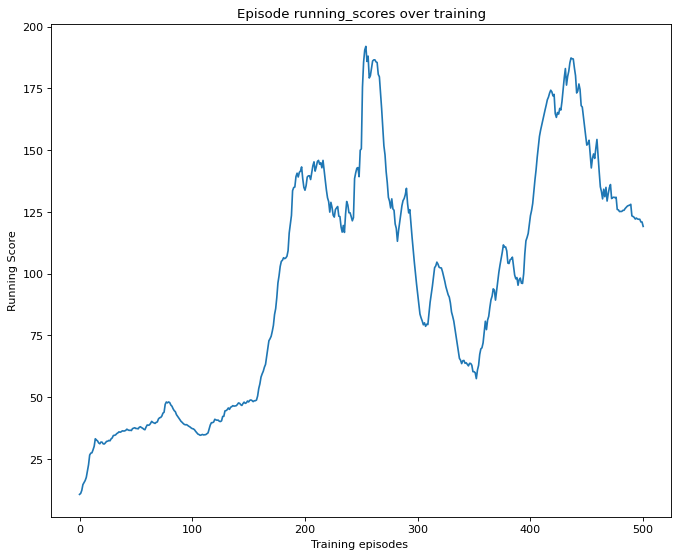

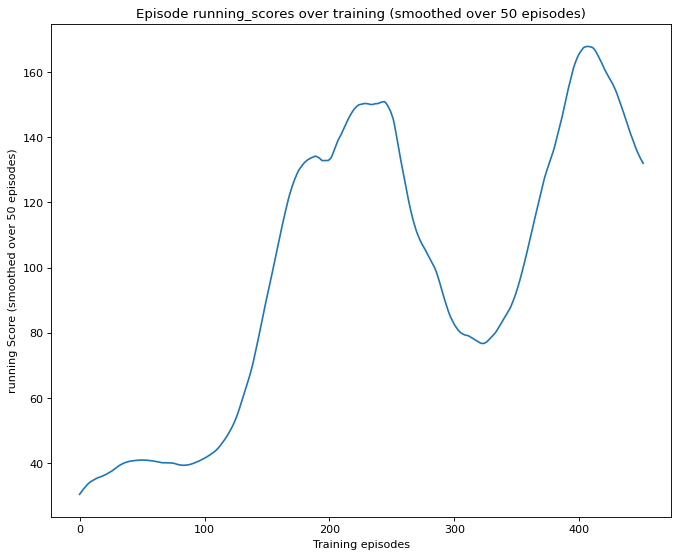

In [ ]:

folder_path='/content/drive/MyDrive/Models/folder_path/'# to save plotted figures

import matplotlib.pyplot as plt


fig_rough=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(scores)
plt.title("Episode scores over training")
plt.xlabel("Training episodes ")
plt.ylabel("Score")


file_name= "fig_scores_Cartpole"
#save fig

plt.savefig(f"{folder_path}{file_name}.png")

# Smooth scores
N = 10
smooth_scores = np.convolve(scores, np.ones((N,))/N, mode='valid')
fig_smooth=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(smooth_scores)
plt.title("Episode scores over training (smoothed over {} episodes)".format(N))
plt.xlabel("Training episodes")
plt.ylabel("Score (smoothed over {} episodes)".format(N))
plt.savefig(f"{folder_path}smooth_{file_name}.png")

##### plotting losses

fig_rough=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(losses)
plt.title("Episode losses over training")
plt.xlabel("Training episodes ")
plt.ylabel("loss")



file_name= "fig_loss_Cartpole"
#save fig

plt.savefig(f"{folder_path}{file_name}.png")

# Smooth scores
N = 50

smooth_losses = np.convolve(losses, np.ones((N,))/N, mode='valid')
fig_smooth=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(smooth_losses)
plt.title("Episode losses over training (smoothed over {} episodes)".format(N))
plt.xlabel("Training episodes")
plt.ylabel("Score (smoothed over {} episodes)".format(N))
plt.savefig(f"{folder_path}smooth_{file_name}.png")

####### plotting running scores

fig_rough=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(running_scores)
plt.title("Episode running_scores over training")
plt.xlabel("Training episodes ")
plt.ylabel("Running Score")



file_name= "fig_Rscores_Cartpole"
#save fig

plt.savefig(f"{folder_path}{file_name}.png")

# Smooth scores
N = 50
smooth_running_scores = np.convolve(running_scores, np.ones((N,))/N, mode='valid')
fig_smooth=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(smooth_running_scores)
plt.title("Episode running_scores over training (smoothed over {} episodes)".format(N))
plt.xlabel("Training episodes")
plt.ylabel("running Score (smoothed over {} episodes)".format(N))
plt.savefig(f"{folder_path}smooth_{file_name}.png")
